# Individual-level characteristics of peer pressure model

In part one, we looked at graph-level attributes of the social pressure process, running many simulations to see how the overall process played out with different parameters. 

In part two we will run one simulation and do a deep-dive into individual nodes from that simulation. This will give us a more precise understanding of the dynamics of our idealized process. 

In [93]:
import plotly.io as pio
pio.renderers.default='notebook'

In [47]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Symbol, diff, lambdify, solve, nsolve, exp
import datetime

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kurtosistest
from scipy.stats import skewtest
from scipy.stats import bernoulli
from sklearn.metrics import mean_absolute_error, log_loss
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
#turning a list into an array is much faster with cython than it is with numpy

%load_ext cython

In [4]:
%%cython

cimport cython
import numpy as np

@cython.boundscheck(False)
cpdef to_array(list inp):
    cdef long[:] arr = np.zeros(len(inp), dtype=long)
    cdef Py_ssize_t idx
    for idx in range(len(inp)):
        arr[idx] = inp[idx]
    return np.asarray(arr)

In [5]:
def run_simulation(G
                   ,n_iterations
                   ,attitude_m
                   ,attitude_sd
                   ,fraction_a
                   ,a_bilateral
                   ,epsilon_sd):
    
    '''Simulates the defined peer pressure process over an existing network graph
    
    Args:
        G (networkx graph): Undirected graph defining peer relationships in a mock society
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Scale of attitude distribution
        fraction_a (float): Bernoulli parameter for setting apathy switch to 0 or 1 for each person
        a_bilateral (bool): switch for bilateral apathy, as opposed to unilateral
        epsilon_sd (float): standard deviation of random factor

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    population = len(G)
    attitudes = np.random.normal(loc = attitude_m
                                 ,scale = attitude_sd
                                 , size = population)
    for j in G.nodes:
        G.nodes[j]['behavior'] = 0

    #before here 
    apathies = bernoulli.rvs(fraction_a, size = population)
    apathy_dict = {i : apathies[i] for i in range(len(apathies))}
    nx.set_node_attributes(G, apathy_dict, "apathy")
        
    node_list = list(G.nodes)
        
    rands = np.random.normal(scale = epsilon_sd,size = (n_iterations,population))
    
    neighbors = [[G.nodes[j] for j in G.neighbors(n)] for n in node_list]
    neighbor_node_list = [n for v,n in zip(neighbors,node_list) for x in v]
    labels = to_array(neighbor_node_list) #gets used later
    
    for i in range(n_iterations):
                
        if a_bilateral:
            neighbor_behaviors = [x['behavior'] if not x['apathy'] else 0 \
                      for v in neighbors for x in v ]
        else:
            neighbor_behaviors = [x['behavior'] if not (x['apathy'] and not x['behavior'] ==1) else 0 \
                                  for v in neighbors for x in v ]

        average_neighbor_behaviors = clever_average(neighbor_behaviors, labels)
        
        new_behavior = np.sign(average_neighbor_behaviors + attitudes + rands[i])
        
        for j, v in zip(G.nodes, new_behavior):
            G.nodes[j]['behavior'] = v
            
    return G, attitudes

#this function is adapted from Vlad Feinberg, at https://vladfeinberg.com/2021/01/07/vectorizing-ragged-arrays.html
#the purpose is to do a more efficient 'jagged mean' via clever vectorization
def clever_average(Xz, labels):
    d = np.diff(labels, prepend=-1) # binary mask where labels change
    
    pos = np.flatnonzero(d) # indices where labels change
    pos = np.append(pos, len(Xz))
    
    Xz = np.concatenate((np.zeros_like(Xz[0:1]), Xz), axis=0)
    Xsums = np.cumsum(Xz, axis=0)

    # reduce by taking differences of accumulations exactly at the
    # endpoints for cluster indices, using pos array
    Xsums = np.diff(Xsums[pos], axis=0)
    counts = np.diff(pos)

    return Xsums / np.maximum(counts, 1)

In order to get many data points, we will run our simulation on a very large Barabasi-Albert graph

In [6]:
G = nx.generators.random_graphs.barabasi_albert_graph(1000000, 8, seed = 0)
result, initial_attitudes = run_simulation(G = G
                   ,n_iterations = 20
                   ,attitude_m = 0
                   ,attitude_sd = 1
                   ,fraction_a = 0
                   ,a_bilateral = False
                   ,epsilon_sd = 0.17)

In [98]:
result_2, initial_attitudes_2 = run_simulation(G = G
                   ,n_iterations = 20
                   ,attitude_m = 0
                   ,attitude_sd = 0.6
                   ,fraction_a = 0
                   ,a_bilateral = False
                   ,epsilon_sd = 0.17)

## 1. Relationships between node characteristics

Now that we have resultant graphs, we can look at how initial attitude informed resultant behavior

## 1a. Symmetrical graph, high attitude SD

In [88]:
def make_result_df(G, initial_attitudes):
    
    for j,attitude in zip(G.nodes,initial_attitudes):
        G.nodes[j]['attitude'] = attitude
        
    behaviors = [G.nodes[n]['behavior'] for n in G]
    average_neighbor_behavior = [np.mean([G.nodes[i]['behavior'] for i in G.neighbors(n)]) for n in G.nodes]
    average_neighbor_attitude = [np.mean([G.nodes[i]['attitude'] for i in G.neighbors(n)]) for n in G.nodes]
    degrees = [G.degree[n] for n in G.nodes]
    
    result_df = pd.DataFrame({'attitude' : initial_attitudes
                              , 'behavior' : behaviors
                              , 'average_neighbor_behavior' : average_neighbor_behavior
                              , 'average_neighbor_attitude' : average_neighbor_attitude
                              , 'degree' : degrees})
    
    return result_df
result_df = make_result_df(G, initial_attitudes)

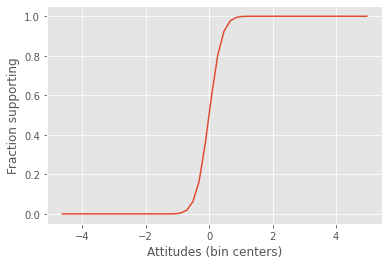

In [94]:
def get_a_bins(result_df):

    attitude_cat = pd.cut(result_df['attitude'], bins = 50)
    result_df.loc[:,'attitude_cat'] = [(x.left+x.right)/2 for x in attitude_cat]
    bin_series = (result_df.groupby('attitude_cat')['behavior'].mean()+1)/2
    return bin_series

bin_series = get_a_bins(result_df)

plt.plot(bin_series)
plt.xlabel('Attitudes (bin centers)')
plt.ylabel('Fraction supporting')
plt.show()

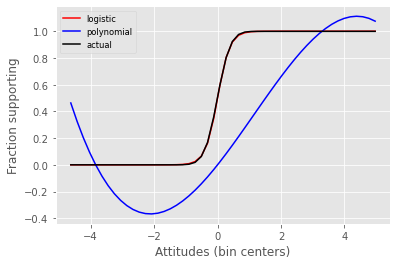

In [97]:
def logifunc(x,A,k, off):
    return A / (1 + np.exp(-k*(x)))+off

def polyfunc(x,a,b,c):
    return a*x**3 + b*x**2 + c*x**1

logi_popt, logi_pcov = curve_fit(logifunc, bin_series.index, bin_series, p0=[9, 1, 0])

poly_popt, poly_pcov = curve_fit(polyfunc, bin_series.index, bin_series, p0=[0,0,0])

plt.plot(bin_series.index, logifunc(bin_series.index,*logi_popt), color = 'red', label = 'logistic')
plt.plot(bin_series.index, polyfunc(bin_series.index,*poly_popt), color = 'blue', label = 'polynomial')
plt.plot(bin_series.index, bin_series, color = 'black', label = 'actual')

plt.xlabel('Attitudes (bin centers)')
plt.ylabel('Fraction supporting')
plt.legend(fontsize = 'small', loc = 'upper left')

plt.show()

This graph is clearly logistic! This tells us that a normal distributions of behaviors leads to a logistic distribution of behaviors

## 1b. Symmetrical graph, medium attitude SD

In [103]:
result_df_2 = make_result_df(result_2, initial_attitudes_2)
bin_series_2 = get_a_bins(result_df_2)


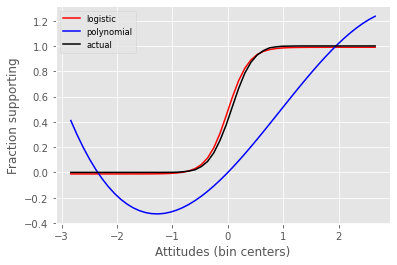

In [104]:
logi_popt, logi_pcov = curve_fit(logifunc, bin_series_2.index, bin_series_2, p0=[9, 1, 0])

poly_popt, poly_pcov = curve_fit(polyfunc, bin_series_2.index, bin_series_2, p0=[0,0,0])

plt.plot(bin_series_2.index, logifunc(bin_series_2.index,*logi_popt), color = 'red', label = 'logistic')
plt.plot(bin_series_2.index, polyfunc(bin_series_2.index,*poly_popt), color = 'blue', label = 'polynomial')
plt.plot(bin_series_2.index, bin_series_2, color = 'black', label = 'actual')

plt.xlabel('Attitudes (bin centers)')
plt.ylabel('Fraction supporting')
plt.legend(fontsize = 'small', loc = 'upper left')

plt.show()

We can now see imperfections of the logistic curve more clearly, but it is still close

## 2. XGB model for resultant behavior

We also know that initial attitude is not the only factor that influences behavior. To see what other factors influence it, we will train an XGB model

## 2a. Symmetrical graph, high attitude SD

In [16]:
train_x, test_x, train_y, test_y = train_test_split(result_df[['attitude','average_neighbor_attitude','degree']]
                                                    ,result_df['behavior']
                                                    ,test_size = 0.1)

In [18]:
xgb_behavior = XGBClassifier().fit(train_x, train_y)
lr_behavior = LogisticRegression().fit(train_x,train_y)

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:12:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
lr_predictions = lr_behavior.predict_proba(test_x)
xgb_predictions = xgb_behavior.predict_proba(test_x)

lr_score = roc_auc_score(test_y, [p[1] for p in lr_predictions])
xgb_score = roc_auc_score(test_y, [p[1] for p in xgb_predictions])

print('Logistic regression score: ' + str(np.round(lr_score*100,2)) + '%')
print('XGB score: ' + str(np.round(xgb_score*100,2)) + '%')

Logistic regression score: 98.43%
XGB score: 98.44%


These scores are both very high, suggesting that the random factors do not have much influence. If they had significant influence, there would be a low ceiling on the highest possible AUC

It is also interesting to note that the logistic regression matches up almost exactly with the XGBoost. Apparently the true function is very nearly a logistic, but there might be a small discrepancy which XGB takes advantage of. Let's observe how the XGB model works

<BarContainer object of 3 artists>

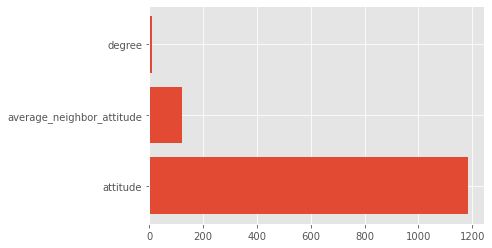

In [23]:
gain_importances = xgb_behavior.get_booster().get_score(importance_type='gain')
plt.style.use('ggplot')

plt.barh([k for k,v in gain_importances.items()], [v for k,v in gain_importances.items()])

With this model, a person's own attitude is about 12x more important than the average of their neighbors. This makes sense considering that we are using an unbiased distribution, and neighboring attitudes are probably close to 0 in general.

Also note that degree has a non-zero importance. It could be the reason why xgboost is very slightly better than logistic, since the effect of degree on behavior must be complicated

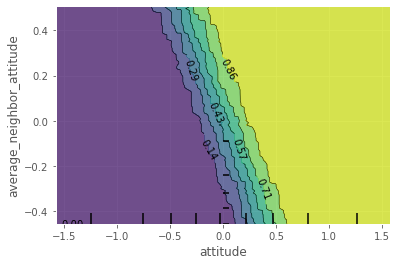

In [24]:
sample = train_x.sample(1000)
plot_partial_dependence(xgb_behavior, sample, [('attitude','average_neighbor_attitude')])

As expected, both attitude and average_neighbor_attitude have significant effects. The boundary lines are linear, which is consistent with a pure logistic regression since the two quantities are summed at the start

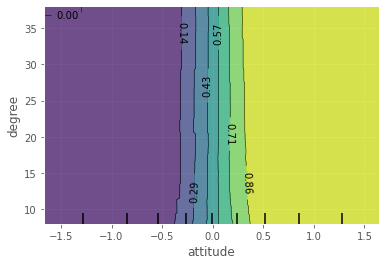

In [26]:
sample = train_x.sample(10000)
plot_partial_dependence(xgb_behavior, sample, [('attitude','degree')])

We can see here that the degree does have some effect. Very low degrees dampen the effect of attitude, perhaps because the attitudes of low-degree nodes don't "get around" as much as those of high degrees. However, the effect is very slight, which is why the logistic regression worked almost just as well

## 1b. 

In [105]:
train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(result_df_2[['attitude','average_neighbor_attitude','degree']]
                                                            ,result_df_2['behavior']
                                                            ,test_size = 0.1)

In [106]:
xgb_behavior_2 = XGBClassifier().fit(train_x_2, train_y_2)
lr_behavior_2 = LogisticRegression().fit(train_x_2,train_y_2)

In [113]:
def get_scores(lr_model, xgb_model, test_x, test_y):

    lr_predictions = lr_model.predict_proba(test_x)
    xgb_predictions = xgb_model.predict_proba(test_x)

    lr_score = roc_auc_score(test_y, [p[1] for p in lr_predictions])
    xgb_score = roc_auc_score(test_y, [p[1] for p in xgb_predictions])

    print('Logistic regression score: ' + str(np.round(lr_score*100,2)) + '%')
    print('XGB score: ' + str(np.round(xgb_score*100,2)) + '%')
    
get_scores(lr_behavior_2, xgb_behavior_2, test_x_2, test_y_2)

Logistic regression score: 96.28%
XGB score: 96.28%


<BarContainer object of 3 artists>

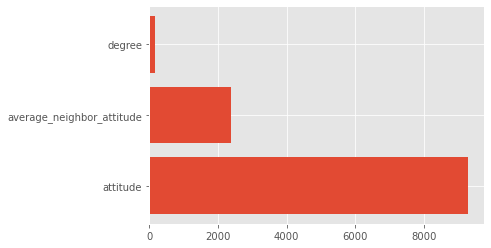

In [111]:
gain_importances_2 = xgb_behavior_2.get_booster().get_score(importance_type='gain')
plt.style.use('ggplot')

plt.barh([k for k,v in gain_importances_2.items()], [v for k,v in gain_importances_2.items()])

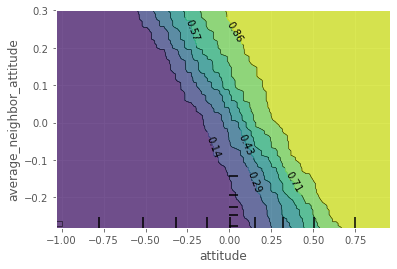

In [114]:
sample_2 = train_x_2.sample(1000)
plot_partial_dependence(xgb_behavior_2, sample_2, [('attitude','average_neighbor_attitude')])

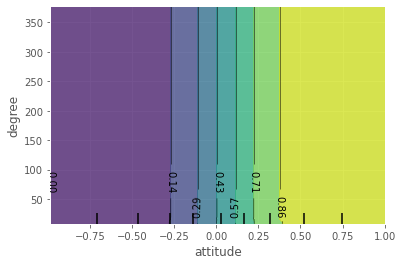

In [119]:
sample_2 = train_x_2.sample(1000)
plot_partial_dependence(xgb_behavior_2, sample_2, [('attitude','degree')])

## 3. Model for resultant neighbor behavior

We can also look at how each node is affecting its neighbors, by regressing on average neighbor attitude

## 3a. Symmetrical graph, high attitude SD

In [43]:
train_n_x, test_n_x, train_n_y, test_n_y = train_test_split(result_df[['attitude','average_neighbor_attitude','degree']]
                                                    ,result_df['average_neighbor_behavior']
                                                    ,test_size = 0.1 )

#we need numbers between 0 and 1 to fit logistic regressions
train_n_y = (1+train_n_y)/2
test_n_y = (1+test_n_y)/2

In [59]:
xgb_n_behavior = XGBRegressor(objective = 'reg:logistic').fit(train_n_x
                                                             ,train_n_y
                                                            )
#following https://stackoverflow.com/questions/61373393/plot-partial-dependence-from-scikit-learn-incorrectly-raises-notfittederror-fo
xgb_n_behavior.dummy_ = "dummy"

In [85]:
from statsmodels.discrete.discrete_model import Logit
logit_model = Logit(train_n_y, train_n_x).fit()

Optimization terminated successfully.
         Current function value: 0.640833
         Iterations 5


In [84]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     average_neighbor_behavior   No. Observations:               900000
Model:                                 Logit   Df Residuals:                   899997
Method:                                  MLE   Df Model:                            2
Date:                       Tue, 02 Nov 2021   Pseudo R-squ.:                 0.07526
Time:                               20:23:38   Log-Likelihood:            -5.7675e+05
converged:                              True   LL-Null:                   -6.2369e+05
Covariance Type:                   nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
attitude                      0.0733      0.002     33.709      0.000       0.069       0.078
average_neighbor_attitude     1.6925      0.008    214.121      0.000       1.677       1.708
degree                        0.0002   6.95e-05      2.184      0.029    1.56e-05       0.000
=============================================================================================
"""

We know the degree relationship must be a spurious correlation, because degree's effect on the result should be symmetrical. And yet, the model is confident with statistical significance that there really is a relationship... this emphasizes that we should be careful when interpreting p-values!

In [86]:
lr_n_predictions = logit_model.predict(test_n_x)
xgb_n_predictions = xgb_n_behavior.predict(test_n_x)

lr_score = mean_absolute_error(test_n_y, lr_n_predictions)
xgb_score = mean_absolute_error(test_n_y, xgb_n_predictions)

print('Logistic regression score: ' + str(np.round(lr_score*100,2)) + '%')
print('XGB score: ' + str(np.round(xgb_score*100,2)) + '%')

Logistic regression score: 7.58%
XGB score: 7.52%


Again, the XGB model does slightly better

<BarContainer object of 3 artists>

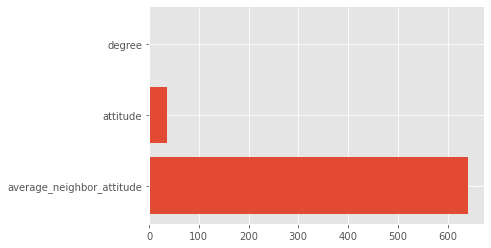

In [63]:
gain_importances = xgb_n_behavior.get_booster().get_score(importance_type='gain')
plt.style.use('ggplot')

plt.barh([k for k,v in gain_importances.items()], [v for k,v in gain_importances.items()])

In this case, degree has no influence. So it seems like each node is equally influential to neighboring nodes no matter how many neighbors it has. 

This is surprising to me, since I assumed nodes with more neighbors would have more influence on their neighbors through feedback loops, but apparently not

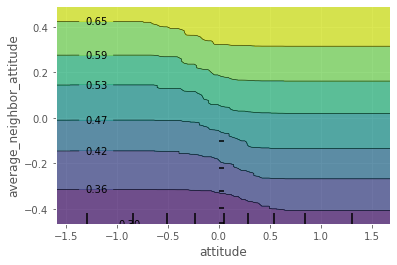

In [64]:
sample = train_n_x.sample(1000)
plot_partial_dependence(xgb_n_behavior, sample, [('attitude','average_neighbor_attitude')])

This shows an interesting relationship between attitude and average_neighbor_attitude. It seems like the neighbor attitude is the overwhelming factor in general, but the attitude does have influence when it is around 0

More to part 2 coming soon :) 